In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from parametres import Paras
from utilities import *
from initialisation import *
from odes import odes_scale_size
import matplotlib.pyplot as plt
from size_scaled_func import *

Initialisation of parametres

In [18]:
def sim_run(N, M, para, assemblenum, tstop, teval):

    ### initialised parametres
    para = Paras(N, M)
    p, number = int_preferences(N, M, para.mu_c, assemblenum)
    D = int_conversion(M, para.Dbase, assemblenum)
    l = int_l(M, para.l_base, assemblenum)
    rho = int_rho(M, para.rho_base, assemblenum)
    vmax = int_vmax(N, M, para.v_max_base, p, number, assemblenum)
    m = int_mt(N, para.m_base, assemblenum)

    ## Initialised Initial conditions
    R0 = int_R(M, para.R0, assemblenum)
    C0 = int_C(N, para.w, assemblenum)

    # Load parametres
    para.paras(C0, R0, l, rho, p, vmax, m, D)
    time = np.linspace(0, tstop, teval)
    pars = (para.l, para.m, para.rho, para.mu, para.km, para.p, para.D, para.v_in_max, para.type, para.B0, para.M0, para.E0, para.alpha, para.gamma, para.R_half)
    y0 = np.concatenate((R0, C0)).reshape(M+N,) # initial conditions

    # run and store
    result = solve_ivp(
    odes_scale_size, t_span=[time[0], time[-1]], y0=y0, t_eval=time, args=pars, dense_output=True)

    Rt = result['y'][0:M]
    Ct = result['y'][M:M+N]
    t = result['t']

    return Rt, Ct, t, para
    

In [44]:
N = 50
M = 100
assemblenum = 1
para = Paras(N, M)

In [45]:
Rt, Ct, t, para = sim_run(N, M, para, assemblenum, tstop=1000, teval=10000)

In [46]:
t.shape

(10000,)

In [47]:
Rt.shape

(100, 10000)

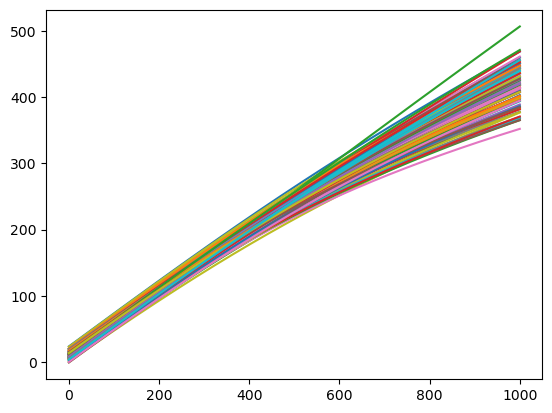

In [48]:
for i in range(M):
    plt.plot(t, Rt[i, :])

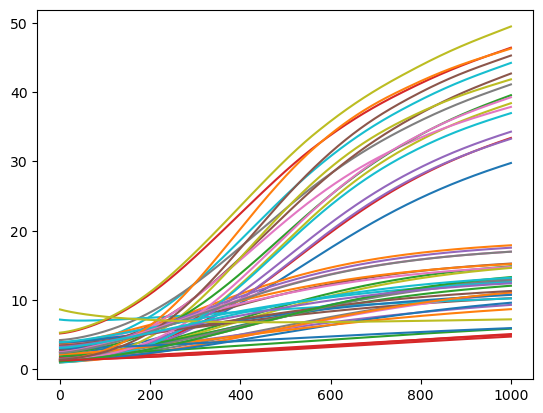

In [49]:
for i in range(N):
    plt.plot(t, Ct[i, :])

In [50]:
Rt.shape

(100, 10000)

In [51]:
species1vg = []

In [52]:
Ct[:, i]

array([2.42511325, 2.53515404, 1.42819606, 1.76736726, 1.3333178 ,
       2.90978783, 3.51698987, 1.29750075, 1.38728575, 3.17962406,
       1.54713811, 3.75234408, 1.87705011, 1.40946829, 2.08257028,
       3.89708686, 1.06424438, 4.2597857 , 1.1069662 , 7.15602825,
       3.91404538, 1.04558203, 2.05407681, 1.62768372, 1.53929176,
       2.78668353, 2.21071776, 1.51512948, 1.04809143, 1.02208647,
       1.22948027, 2.20367467, 2.41564263, 5.22707683, 2.52530631,
       3.47984607, 1.27627808, 1.21050472, 5.34220286, 3.9436518 ,
       3.03625346, 1.32884812, 1.17209271, 1.33383055, 3.27754093,
       1.40757927, 2.49056265, 2.38980999, 8.57395285, 3.13451382])

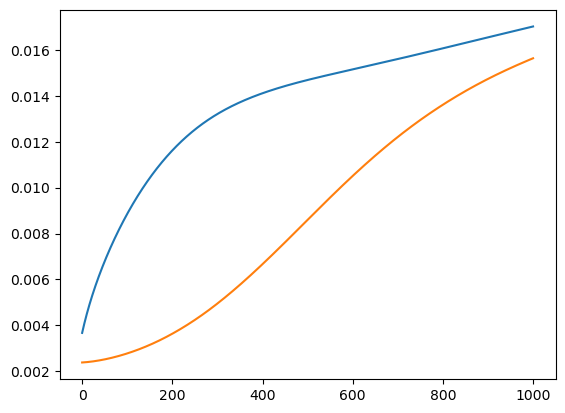

In [53]:
species1vg = []
m1 = []
for i in range(len(t)):
    resourcet = Rt[:, i].reshape(M, 1)
    masst = Ct[:, i].reshape(N, 1)
    v_in = vin(para.p, resourcet, para.R_half, vmax=para.v_in_max, type=2)
    v_in = scale_vin(v_in, masst, para.B0, para.alpha)
    v_g = vgrow(v_in, para.l)[0]
    species1vg.append(v_g)
    m_scale = scale_mt(para.m, masst, para.M0, para.alpha)[0]
    m1.append(m_scale)


plt.plot(t, species1vg)
plt.plot(t, m1)